# Time Series forecasting with XGBoost

In this notebook we will walk through forecasting time series data with extreme gradient boosting also called XGBoost.  
We will be using weather data in combination with realized solar power supply.

In [1]:
from utils import (LastOnlyRegressorChain, plot_error_over_horizon, plot_most_influential_chained_prediction, plot_random_forecast)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import xgboost as xgb
import pickle
import os


from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.multioutput import RegressorChain, MultiOutputRegressor
from statsmodels.graphics.tsaplots import plot_pacf, pacf
from dataclasses import dataclass
from typing import List, Union
from tueplots.constants.color import rgb

In [2]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.close('all')
plt.style.use('default')

In [3]:
os.mkdir('tmp') if not os.path.exists('tmp') else None

## 1. Data Loading

We will be using weather data on a rough grid in Germany combined with the realized solar power supply in Germany in Mega Watts.  
We have four years of data available, 2019-2022.

In [4]:
supply = pd.read_csv('data/Realised_Supply_Germany.csv', index_col=0, sep=';')
supply = supply[['Solar Power [MW]']]
supply.index = pd.to_datetime(supply.index, format='%d.%m.%y %H:%M')
supply['Solar Power [MW]'] = supply['Solar Power [MW]'].str.replace('.', '', regex=False)
supply['Solar Power [MW]'] = supply['Solar Power [MW]'].str.replace(',', '.', regex=False)
supply['Solar Power [MW]'] = pd.to_numeric(supply['Solar Power [MW]'], errors='raise')


In [5]:
weather = pd.read_csv('data/Weather_Data_Germany.csv', sep=',', decimal='.')
weather.time = pd.to_datetime(weather.time, format='%Y-%m-%d %H:%M:%S')
weather.set_index('time', inplace=True)
weather = weather.drop(columns=['forecast_origin'])

In [6]:
weather2022 = pd.read_csv('data/Weather_Data_Germany_2022.csv', sep=',', decimal='.')
weather2022.time = pd.to_datetime(weather2022.time, format='%Y-%m-%d %H:%M:%S')
weather2022.set_index('time', inplace=True)
weather2022 = weather2022.drop(columns=['forecast_origin'])

In [7]:
weather = pd.concat([weather,weather2022])
print(f"Start date: {weather.index.min()}")
print(f"End date: {weather.index.max()}")

Start date: 2019-01-01 00:00:00
End date: 2022-12-31 23:00:00


In [8]:
weather.head()

,longitude,latitude,cdir,z,msl,blh,tcc,u10,v10,t2m,ssr,tsr,sund,tp,fsr,u100,v100
time,,,,,,,,,,,,,,,,,
2019-01-01,5.8,54.2,0.0,-2.766602,102439.914,766.03015,0.304399,11.806978,2.823900,282.04110,0.0,0.0,0.0,0.0,0.000860,15.666069,3.153420
2019-01-01,5.8,53.2,0.0,-6.159180,102795.230,842.93190,0.945699,6.628730,1.767059,281.28223,0.0,0.0,0.0,0.0,0.254992,10.824787,2.401394
2019-01-01,5.8,52.2,0.0,478.410160,103077.450,862.93030,0.999504,4.976940,1.899902,280.48530,0.0,0.0,0.0,0.0,0.439765,8.450895,2.586425
2019-01-01,5.8,51.2,0.0,237.821290,103310.510,619.56150,0.999992,3.810944,1.201527,280.26593,0.0,0.0,0.0,0.0,0.645616,6.853557,1.614200
2019-01-01,5.8,50.2,0.0,4681.780000,103456.680,385.46838,0.999992,3.689941,-0.424220,277.94235,0.0,0.0,0.0,0.0,0.361133,6.055728,-0.896704


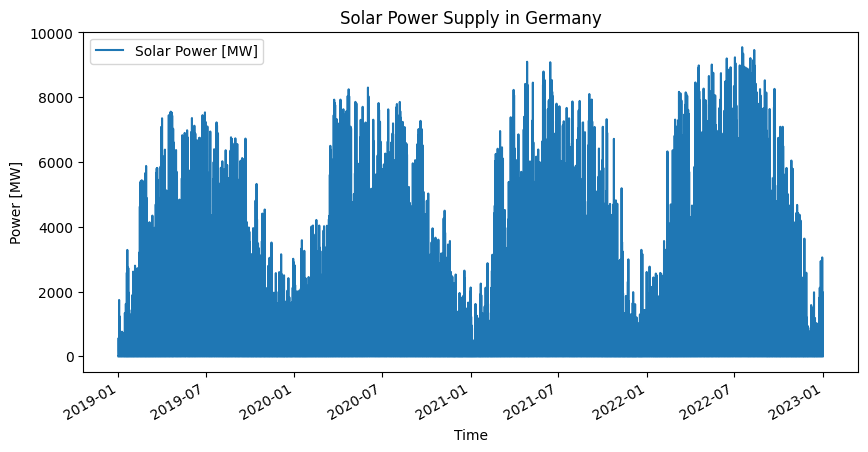

In [9]:
# Plot the supply data
supply.plot(figsize=(10, 5), title='Solar Power Supply in Germany', ylabel='Power [MW]', xlabel='Time')
plt.show()

As we can see, there is a clear seasonality in the data. We could analyze this in much more depth but let's go with the route of assuming all common seasonalities (yearly, monthly, weekly and daily) and letting the feature selection sort out which ones we actually need.  
XGBoost can handle the rest.

# 2 Data Preprocessing

## 2.1 Reduce time precision to match weather

The supply data has values every 15 minutes, but the weather data only has hourly data so let's match that by resampling the supply data.  
We basically sum every 4 values to form hourly measurements.

In [10]:
# Match time precision by summing up to the hour
supply = supply.resample('H').sum()

/tmp/ipykernel_22922/1631454130.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  supply = supply.resample('H').sum()


## 2.2 Aggregate over weather stations

The weather data gets measured at many different stations across Germany. To leverage this, we would need similar data for the supply measurements or some knowledge on where the supply is generated.  
But since we do not have that, we will average the weather from different locations naively.

In [11]:
# Aggregate weather data from different weather stations
weather = weather.drop(columns=['z', 'latitude', 'longitude'])
weather = weather.groupby(weather.index).mean()

## 2.3 Normalize values

Scaling the features is not always necessary for XGBoost is a tree-based learner.  
However, the weather data has stark differences in magnitude of feature values and in this case it is beneficial to normalize the features to get them into the same range.

In [12]:
scaler = StandardScaler()
weather_scaled = scaler.fit_transform(weather)
weather_scaled = pd.DataFrame(weather_scaled, index=weather.index, columns=weather.columns)

## 2.4 Create Time Series features
We could provide the date to the model but is often more effective to provide additional information and split the info into distinct features.  
We will add the most common features and later check which ones we actually need.

In [13]:
# Add time features
weather_scaled['hour'] = weather_scaled.index.hour
weather_scaled['dayofweek'] = weather_scaled.index.dayofweek
weather_scaled['month'] = weather_scaled.index.month
weather_scaled['dayofyear'] = weather_scaled.index.dayofyear
weather_scaled['year'] = weather_scaled.index.year
weather_scaled['weekofyear'] = weather_scaled.index.isocalendar().week
weather_scaled['dayofmonth'] = weather_scaled.index.day

## 2.5 Train/Test Split
Splitting in time series data should always be in order and contain a whole season, so we are using 2022 as the test set.

In [14]:
# Train-test split
cutoff_date = pd.to_datetime('2022-01-01')

X_train = weather_scaled[weather_scaled.index < cutoff_date]
X_test = weather_scaled[weather_scaled.index >= cutoff_date]
y_train = supply[supply.index < cutoff_date]
y_test = supply[supply.index >= cutoff_date]
# Write the data to CSV files
X_train.to_csv('tmp/X_train.csv', sep=';', decimal=',')
X_test.to_csv('tmp/X_test.csv', sep=';', decimal=',')
y_train.to_csv('tmp/y_train.csv', sep=';', decimal=',')
y_test.to_csv('tmp/y_test.csv', sep=';', decimal=',')

# 3 Feature Selection

There are still quite a lot of features in the weather data. We can use Lasso Regression to find the most important ones.  
Lasso uses L1 regularization which penalizes non-zero values, which means we can use it for feature selection by choosing all features with non-zero coefficients.

In [15]:
# Load Data
X_train = pd.read_csv('tmp/X_train.csv', sep=';', decimal=',', index_col=0)
X_test = pd.read_csv('tmp/X_test.csv', sep=';', decimal=',', index_col=0)
y_train = pd.read_csv('tmp/y_train.csv', sep=';', decimal=',', index_col=0)
y_test = pd.read_csv('tmp/y_test.csv', sep=';', decimal=',', index_col=0)

In [16]:
lasso_cv = LassoCV(cv= 5, random_state=1312).fit(X_train, y_train.squeeze())
best_alpha = lasso_cv.alpha_

lasso = Lasso(alpha=best_alpha, random_state=1312)
_ = lasso.fit(X_train, y_train.squeeze())

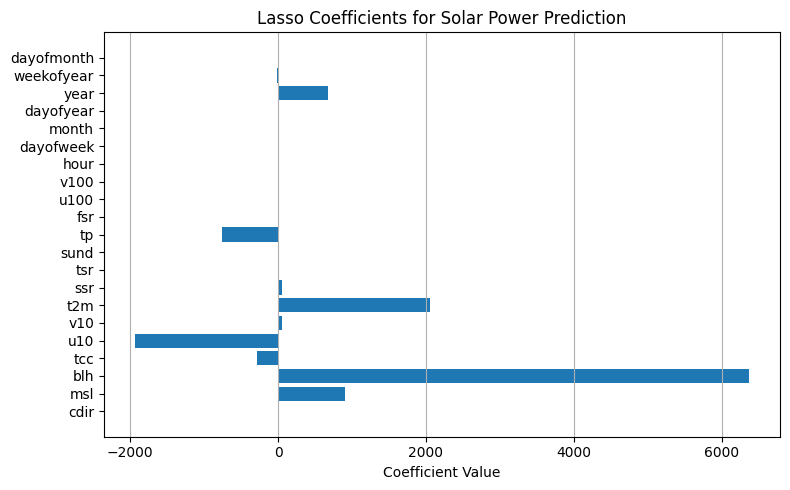

In [17]:
# Plot coefficients
plt.figure(figsize=(8, 5))
plt.barh(X_train.columns, lasso.coef_)
plt.xlabel('Coefficient Value')
plt.title('Lasso Coefficients for Solar Power Prediction')
plt.grid(axis='x')
plt.tight_layout()

In [18]:
# Drop Features with zero coefficients
X_train_selected = X_train.loc[:, lasso.coef_ != 0]
X_test_selected = X_test.loc[:, lasso.coef_ != 0]
print(f"Number of features after Lasso: {X_train_selected.shape[1]}")

Number of features after Lasso: 13


In [19]:
X_test_selected.columns

Index(['msl', 'blh', 'tcc', 'u10', 'v10', 't2m', 'ssr', 'tp', 'hour',
       'dayofyear', 'year', 'weekofyear', 'dayofmonth'],
      dtype='object')

After the selection process we are left with 13 features. It is not strictly necessary to do feature selection for XGBoost as the model can handle big feature spaces and our feature spaces was not that big to begin with.  
But we will see later that almost all the important information is contained in these 13 features and we don't need all of them. 

In [20]:
# Save the selected features
X_train_selected.to_csv('tmp/X_train_selected.csv', sep=';', decimal=',')
X_test_selected.to_csv('tmp/X_test_selected.csv', sep=';', decimal=',')

# 4. Model Training

In [21]:
# Load data
X_train_selected = pd.read_csv('tmp/X_train_selected.csv', sep=';', decimal=',', index_col=0)
X_test_selected = pd.read_csv('tmp/X_test_selected.csv', sep=';', decimal=',', index_col=0)
X_train = pd.read_csv('tmp/X_train.csv', sep=';', decimal=',', index_col=0)
X_test = pd.read_csv('tmp/X_test.csv', sep=';', decimal=',', index_col=0)
y_train = pd.read_csv('tmp/y_train.csv', sep=';', decimal=',', index_col=0)
y_test = pd.read_csv('tmp/y_test.csv', sep=';', decimal=',', index_col=0)

In [22]:
# Set up data structure for evaluation later

@dataclass
class ModelEvaluation:
    model_name: str
    model: object
    horizon: int
    y_pred: np.ndarray
    R2_score: float
    RMSE: Union[float, List[float]]
    MAE: Union[float, List[float]]

evaluations = {}


## 4.1 Prediction
Lets start with the simplest model and task. We train to take a datapoint of weather features $\mathbf X_t$ and predict the corresponding Solar Supply $ y_t$ both at time point $t$.

### 4.1.1 Lasso
We start with a very simple baseline model and for that we use Lasso.


In [23]:
# Lasso Prediction
lasso_cv = LassoCV(cv= 5, random_state=1312).fit(X_train_selected, y_train.squeeze())
best_alpha = lasso_cv.alpha_

lasso = Lasso(alpha=best_alpha, max_iter=1000, random_state=1312)
_ = lasso.fit(X_train_selected, y_train.squeeze())

y_pred_lasso = lasso.predict(X_test_selected)
r2_score_lasso = lasso.score(X_test_selected, y_test.squeeze())

In [24]:
lasso_eval = ModelEvaluation(
    model_name='Lasso',
    model=lasso,
    horizon=1,
    y_pred=y_pred_lasso,
    R2_score=r2_score_lasso,
    RMSE=root_mean_squared_error(y_test.squeeze(), y_pred_lasso),
    MAE=mean_absolute_error(y_test.squeeze(), y_pred_lasso)
)
evaluations[lasso_eval.model_name] = lasso_eval
print(f"{lasso_eval.model_name}: R2: {lasso_eval.R2_score}, RMSE: {lasso_eval.RMSE}, MAE: {lasso_eval.MAE}")

Lasso: R2: 0.7847323675240458, RMSE: 4429.891845241874, MAE: 3389.2582629639046


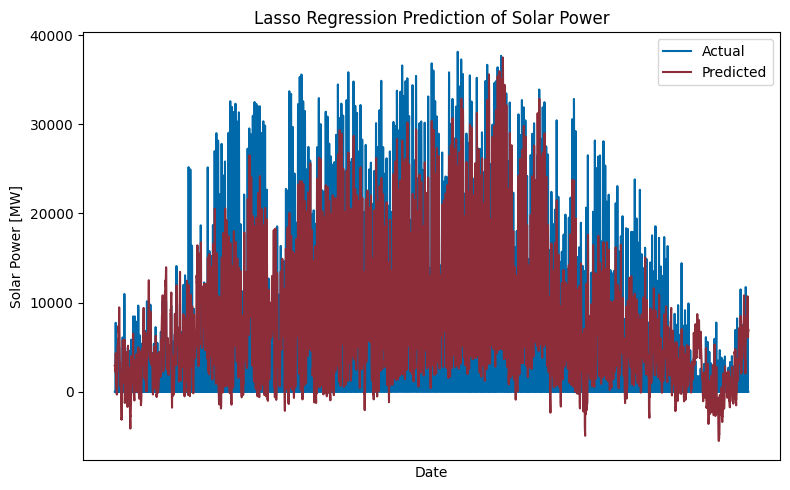

In [25]:
# Plot Lasso Prediction
plt.figure(figsize=(8, 5))
plt.plot(y_test.index, y_test, label='Actual', color=rgb.tue_blue)
plt.plot(y_test.index, y_pred_lasso, label='Predicted', color=rgb.tue_red)
plt.xlabel('Date')
plt.ylabel('Solar Power [MW]')
plt.xticks([])
plt.title('Lasso Regression Prediction of Solar Power')
plt.legend()
plt.tight_layout()
plt.show()

### 4.1.2 XGBoost

Now we can start with the actual model we want to train. To validate our feature selection process, let's also train a model on the complete dataset and compare.

In [26]:
# XGBoost Prediction
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    random_state=1312,
)

xgb_model.fit(X_train_selected, y_train.squeeze())

xgb_pred = xgb_model.predict(X_test_selected)
r2_score_xgb = xgb_model.score(X_test_selected, y_test.squeeze())

In [27]:
# Feature selection check
xgb_model_naive = xgb.XGBRegressor(
    n_estimators=1000,
    random_state=1312,
)
xgb_model_naive.fit(X_train, y_train.squeeze())
xgb_pred_naive = xgb_model_naive.predict(X_test)
r2_score_xgb_naive = xgb_model_naive.score(X_test, y_test.squeeze())

In [28]:
xgb_eval = ModelEvaluation(
    model_name='XGBoost',
    model=xgb_model,
    horizon=1,
    y_pred=xgb_pred,
    R2_score=r2_score_xgb,
    RMSE=root_mean_squared_error(y_test.squeeze(), xgb_pred),
    MAE=mean_absolute_error(y_test.squeeze(), xgb_pred)
)
xgb_eval_naive = ModelEvaluation(
    model_name='XGBoost Naive',
    model=xgb_model_naive,
    horizon=1,
    y_pred=xgb_pred_naive,
    R2_score=r2_score_xgb_naive,
    RMSE=root_mean_squared_error(y_test.squeeze(), xgb_pred_naive),
    MAE=mean_absolute_error(y_test.squeeze(), xgb_pred_naive)
)
evaluations[xgb_eval.model_name] = xgb_eval
evaluations[xgb_eval_naive.model_name] = xgb_eval_naive
print(f"{xgb_eval.model_name}: R2: {xgb_eval.R2_score}, RMSE: {xgb_eval.RMSE}, MAE: {xgb_eval.MAE}")
print(f"{xgb_eval_naive.model_name}: R2: {xgb_eval_naive.R2_score}, RMSE: {xgb_eval_naive.RMSE}, MAE: {xgb_eval_naive.MAE}")

XGBoost: R2: 0.9712215521555476, RMSE: 1619.710655562959, MAE: 949.0809680836198
XGBoost Naive: R2: 0.9740071216935442, RMSE: 1539.3271972932725, MAE: 910.1493204327858


We can see only a very slight difference in any evaluation criteria between the naive dataset and the one with only the selected features.  
As I mentioned earlier, we don't need to perform feature selection for XGBoost and this proves it for this dataset.  
We will still use only the selected features as the increase in error is so irrelevant but the training time goes does significantly.

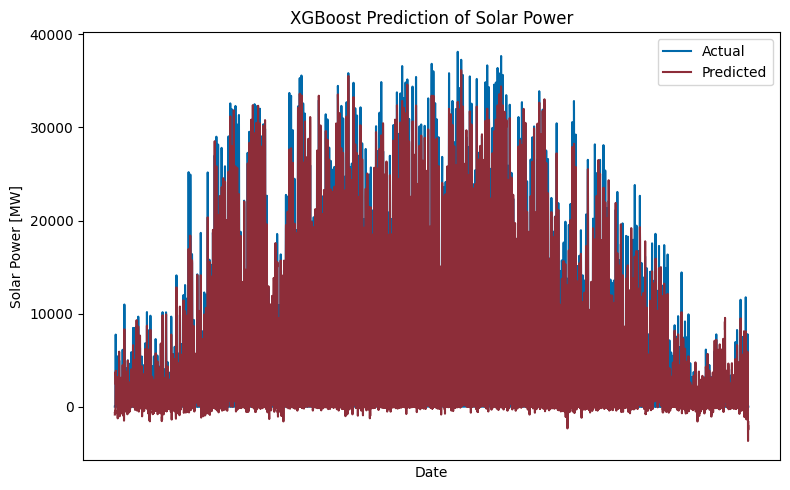

In [29]:
# Plot XGBoost Prediction
plt.figure(figsize=(8, 5))
plt.plot(y_test.index, y_test, label='Actual', color=rgb.tue_blue)
plt.plot(y_test.index, xgb_pred, label='Predicted', color=rgb.tue_red)
plt.xlabel('Date')
plt.ylabel('Solar Power [MW]')
plt.xticks([])
plt.title('XGBoost Prediction of Solar Power')
plt.legend()
plt.tight_layout()
plt.show()

This and the evaluation measurements clearly show that XGBoost works and outperforms our baseline significantly.

## 4.2 Forecasting
Now we can increase our horizon to the 24 hours we actually want.  
With XGBoost, we do this by training a regressor for every step ahead. So we end up with 24 regressors each specialized to predict $i$ hours ahead of $t$.
We start by training these regressors as parallel predictors that are unaware of each other.

We define $\mathbf X \rightarrow Y^h: f$ as the overall model. We can define $f$ as $f(\mathbf X_t) = (f_1(\mathbf X_t), \dots, f_h(\mathbf X_t)) $ where $f_i$ is one XGBoost regressor.

### 4.2.1 Parallel XGBoost

In [30]:
# Transform the target y to include the next h hours
horizon = 24
y_train_horizon = y_train.copy()
y_test_horizon = y_test.copy()
for i in range(1, horizon):
    y_train_horizon[f"t+{i}"] = y_train.shift(-i)
    y_test_horizon[f"t+{i}"] = y_test.shift(-i)
    
y_train_horizon = y_train_horizon.dropna()
y_test_horizon = y_test_horizon.dropna()
X_train_horizon = X_train_selected.loc[y_train_horizon.index]
X_test_horizon = X_test_selected.loc[y_test_horizon.index]

# Save the transformed data
y_test_horizon.to_csv('tmp/y_test_horizon.csv', sep=';', decimal=',',)

In [31]:
# Train a MultiOutput Regressor with XGBoost
xgb_parallel = MultiOutputRegressor(
    xgb.XGBRegressor(
        n_estimators=1000,
        random_state=1312,
    )
)
xgb_parallel.fit(X_train_horizon, y_train_horizon)
xgb_pred_parallel = xgb_parallel.predict(X_test_horizon)
r2_score_xgb_parallel = xgb_parallel.score(X_test_horizon, y_test_horizon)

In [32]:
xgb_parallel_eval = ModelEvaluation(
    model_name='Parallel',
    model=xgb_parallel,
    horizon=horizon,
    y_pred=pd.DataFrame(xgb_pred_parallel, index=y_test_horizon.index),
    R2_score=r2_score_xgb_parallel,
    RMSE=[root_mean_squared_error(y_test_horizon.iloc[:, i], xgb_pred_parallel[:, i]) for i in range(horizon)],
    MAE=[mean_absolute_error(y_test_horizon.iloc[:, i], xgb_pred_parallel[:, i]) for i in range(horizon)]
)
evaluations[xgb_parallel_eval.model_name] = xgb_parallel_eval
print(f"{xgb_parallel_eval.model_name}: R2: {xgb_parallel_eval.R2_score}")

Parallel: R2: 0.9359478950500488


The overall RMSE and MAE values can still be informative but much more interesting are the RMSE/MAE measurements over the horizon. The plot shows the mean errors of the $f_i$ regressors which predict the horizon.  
This shows us how much the predictions deteriorate as we go further into the future.

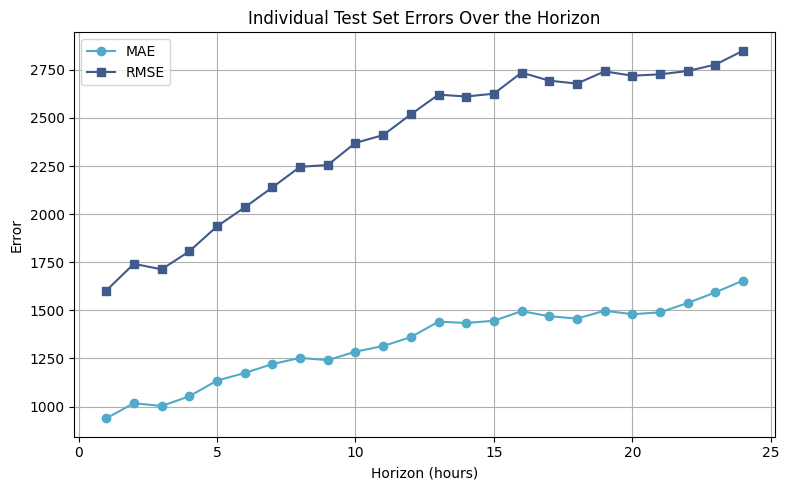

In [33]:
# Plot XGBoost Parallel Prediction
plot_error_over_horizon(y_test_horizon,xgb_pred_parallel, horizon=horizon)

As expected, the error increases as the predictions go into the future but a magnitude of below 100% increase of error is already a very good result.

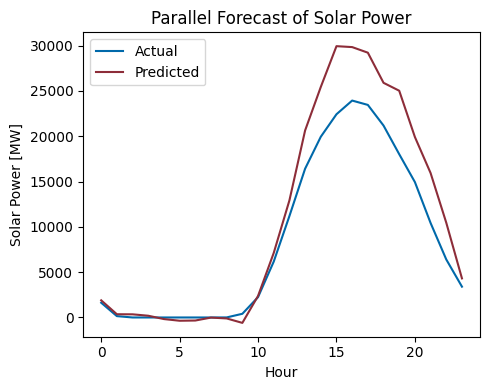

In [34]:
# Plot random forecast from the XGBoost Parallel Prediction
plot_random_forecast(y_test_horizon, xgb_pred_parallel, model_name=xgb_parallel_eval.model_name)

Looking at some predictions the model made, we can see very jagged and not smooth predictions. This makes sense, as the model has no idea what the previous prediction was so it can not really be smooth.

### 4.2.2 Chained XGBoost

We want to reduce the increase of error over time and get the predictions to be smoother. 
To this end, let's try to give the model more information about the previous predictions and see what that leads to.
We can make the model autoregressive by giving regressor $i$ all previous predictions from $[0,i-1]$.

The new model definition is $\mathbf X \rightarrow Y^h: f$ as the overall model. Define $f$ as $f(\mathbf X_t) = (y_1, \dots, y_h)) $ where $y_i$ is the output of one XGBoost regressor $f_i$.  
$y_i = f_i(\mathbf X_t + \sum_j^{i-1}y_j)$ with + being concatenation of vectors.

In [35]:
# Train a RegressorChain with XGBoost
xgb_chained = RegressorChain(
    xgb.XGBRegressor(
        n_estimators=1000,
        random_state=1312,
    )
)
xgb_chained.fit(X_train_horizon, y_train_horizon)
xgb_pred_chained = xgb_chained.predict(X_test_horizon)
r2_score_xgb_chained = xgb_chained.score(X_test_horizon, y_test_horizon)

In [36]:
xgb_chained_eval = ModelEvaluation(
    model_name='Chained',
    model=xgb_chained,
    horizon=horizon,
    y_pred=pd.DataFrame(xgb_pred_chained, index=y_test_horizon.index),
    R2_score=r2_score_xgb_chained,
    RMSE=[root_mean_squared_error(y_test_horizon.iloc[:, i], xgb_pred_chained[:, i]) for i in range(horizon)],
    MAE=[mean_absolute_error(y_test_horizon.iloc[:, i], xgb_pred_chained[:, i]) for i in range(horizon)]
)
evaluations[xgb_chained_eval.model_name] = xgb_chained_eval
print(f"{xgb_chained_eval.model_name}: R2: {xgb_chained_eval.R2_score}")

Chained: R2: 0.7448082179423903


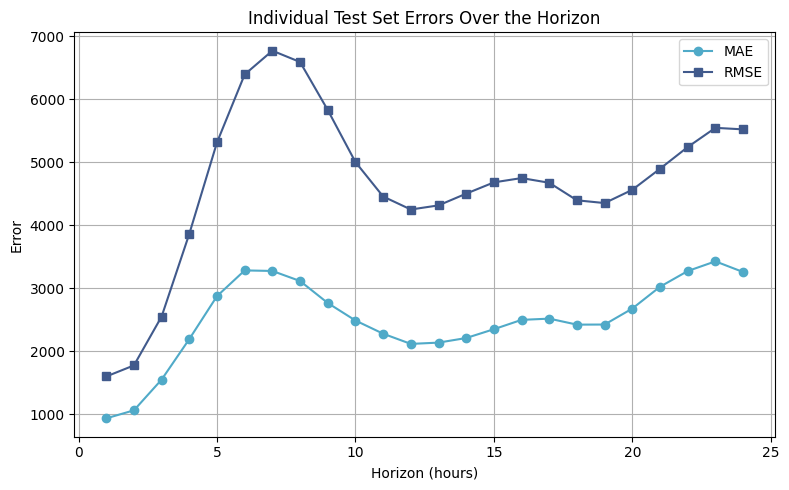

In [37]:
# Plot XGBoost Parallel Prediction
plot_error_over_horizon(y_test_horizon,xgb_pred_chained, horizon=horizon)

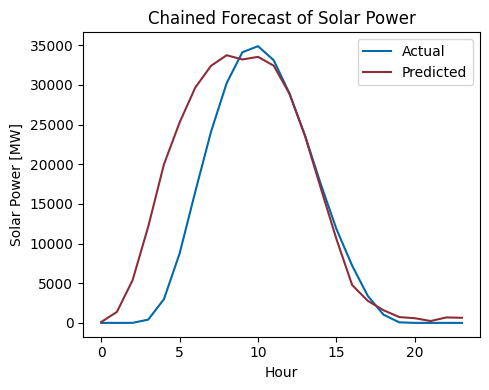

In [38]:
# Plot random forecast from the XGBoost Chained Prediction
plot_random_forecast(y_test_horizon, xgb_pred_chained, model_name=xgb_chained_eval.model_name)

The forecasts made by this model look much smoother than the previous ones. Unfortunately, the smoothness brings error with it as we now give to much weight to previous regressors prediction and not the actual features.

Does the model even need all previous predictions? Lets look at the most important one at every time step. XGBoost gives us feature importance that show us exactly that (and more).

The plot shows, which of the $y_j$ a regressor $f_i$ receives is the most important one.

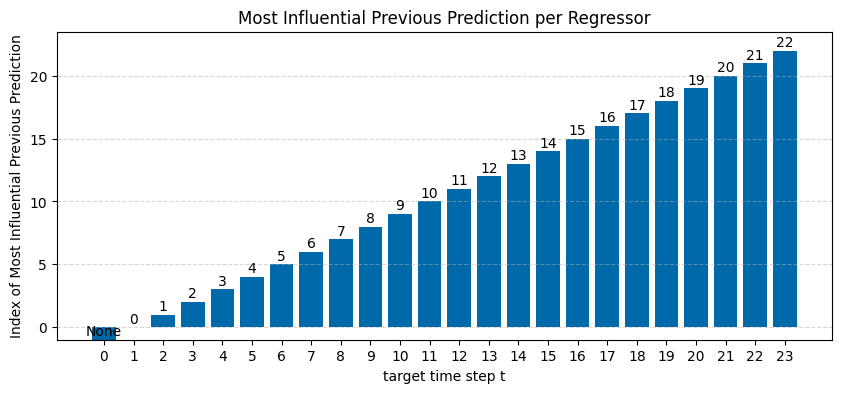

In [39]:
# Feature importance for the chained model
importances = [list(estimator.get_booster().get_score().values()) for estimator in xgb_chained.estimators_]
plot_most_influential_chained_prediction(importances, 13)

For every regressor $f_i$ the most important $y_j$ is $y_{i-1}$

### 4.2.3 Last Only Chained XGBoost

We now leverage the fact that the model relies on the prior prediction the most and only provide that in order to bring the error down again.

The new model definition is $\mathbf X \rightarrow Y^h: f$ as the overall model. Define $f$ as $f(\mathbf X_t) = (y_1, \dots, y_h)) $ where $y_i$ is the output of one XGBoost regressor $f_i$.  
$y_i = f_i(\mathbf X_t + y_{i-1})$ with + being concatenation of vectors.

In [40]:
# Last Only Regressor Chain
last_only_chain = LastOnlyRegressorChain(
    xgb.XGBRegressor(
        n_estimators=1000,
        random_state=1312,
    )
)
last_only_chain.fit(X_train_horizon.to_numpy(), y_train_horizon.to_numpy())
xgb_pred_last_only = last_only_chain.predict(X_test_horizon.to_numpy())
r2_score_xgb_last_only = last_only_chain.score(X_test_horizon.to_numpy(), y_test_horizon)

In [41]:
xgb_last_only_eval = ModelEvaluation(
    model_name='Chained Last Only',
    model=last_only_chain,
    horizon=horizon,
    y_pred=pd.DataFrame(xgb_pred_last_only, index=y_test_horizon.index),
    R2_score=r2_score_xgb_last_only,
    RMSE=[root_mean_squared_error(y_test_horizon.iloc[:, i], xgb_pred_last_only[:, i]) for i in range(horizon)],
    MAE=[mean_absolute_error(y_test_horizon.iloc[:, i], xgb_pred_last_only[:, i]) for i in range(horizon)]
)
evaluations[xgb_last_only_eval.model_name] = xgb_last_only_eval
print(f"{xgb_last_only_eval.model_name}: R2: {xgb_last_only_eval.R2_score}")

Chained Last Only: R2: 0.7845825072389685


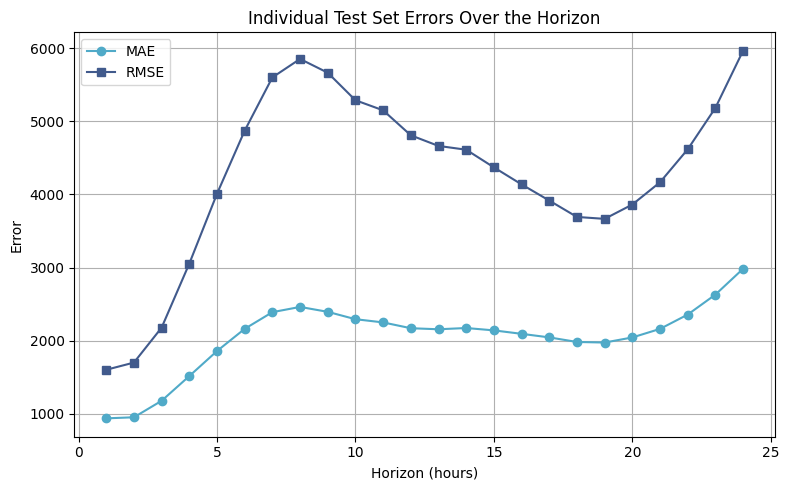

In [42]:
# Plot XGBoost Parallel Prediction
plot_error_over_horizon(y_test_horizon,xgb_pred_last_only, horizon=horizon)

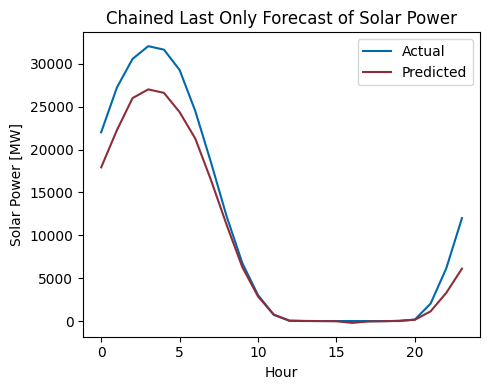

In [43]:
# Plot random forecasts from the XGBoost Last Only Chained Prediction
plot_random_forecast(y_test_horizon, xgb_pred_last_only, model_name=xgb_last_only_eval.model_name)

Nice, this brought the error down (not to parallel levels) but we kept the smoothness of forecasts.

### 4.2.4 Lagged Features
Ok including the previous prediction result resulted in some benefit but we can also include the previous time steps of X.  
This is common practice in dealing with time series. If we want to know how many time steps back we need to go, we can look at the partial auto correlation.

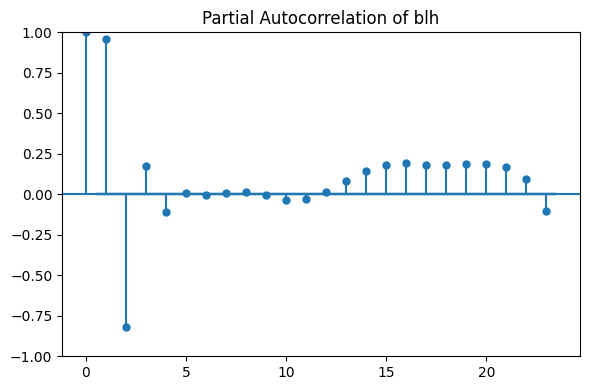

In [44]:
# Partial autocorrelation plot for most important feature
fig, ax = plt.subplots(figsize=(6, 4))
plot_pacf(X_train_horizon["blh"], lags=horizon-1, ax=ax)
ax.set_title('Partial Autocorrelation of blh')
plt.tight_layout()
plt.show()

For BLH we can see that the PACF for lags 1 and 2 are much more relevant than the others. We can do this for every feature and include those lags.

In [45]:
# Get lags over threshhold for every feature using PACF
lags= {}
for col in X_train_horizon.columns:
    pacf_values = pacf(X_train_horizon[col], nlags=horizon-1)
    lags[col] = np.where((np.abs(pacf_values) > 0.5) & (np.abs(pacf_values) < 1))[0].tolist()


In [46]:
# Create lagged features
X_lagged_train = X_train_horizon.copy()
X_lagged_test = X_test_horizon.copy()
for col, lag_list in lags.items():
    for lag in lag_list:
        X_lagged_train[f"{col}_lag_{lag}"] = X_lagged_train[col].shift(lag)
        X_lagged_test[f"{col}_lag_{lag}"] = X_lagged_test[col].shift(lag)
        
X_lagged_train = X_lagged_train.dropna()
X_lagged_test = X_lagged_test.dropna()
y_lagged_train = y_train_horizon.loc[X_lagged_train.index]
y_lagged_test = y_test_horizon.loc[X_lagged_test.index]

# store y_lagged_test as csv
y_lagged_test.to_csv('tmp/y_lagged_test.csv', sep=';', decimal=',')

In [47]:
# Train a parallel XGBoost model with lagged features
xgb_lagged = MultiOutputRegressor(
    xgb.XGBRegressor(
        n_estimators=1000,
        random_state=1312,
    )
)
xgb_lagged.fit(X_lagged_train, y_lagged_train)
xgb_pred_lagged = xgb_lagged.predict(X_lagged_test)
r2_score_xgb_lagged = xgb_lagged.score(X_lagged_test, y_lagged_test)

In [48]:
xgb_lagged_eval = ModelEvaluation(
    model_name='Lagged parallel',
    model=xgb_lagged,
    horizon=horizon,
    y_pred=pd.DataFrame(xgb_pred_lagged, index=y_lagged_test.index),
    R2_score=r2_score_xgb_lagged,
    RMSE=[root_mean_squared_error(y_lagged_test.iloc[:, i], xgb_pred_lagged[:, i]) for i in range(horizon)],
    MAE=[mean_absolute_error(y_lagged_test.iloc[:, i], xgb_pred_lagged[:, i]) for i in range(horizon)]
)
evaluations[xgb_lagged_eval.model_name] = xgb_lagged_eval
print(f"{xgb_lagged_eval.model_name}: R2: {xgb_lagged_eval.R2_score}")

Lagged parallel: R2: 0.9375138282775879


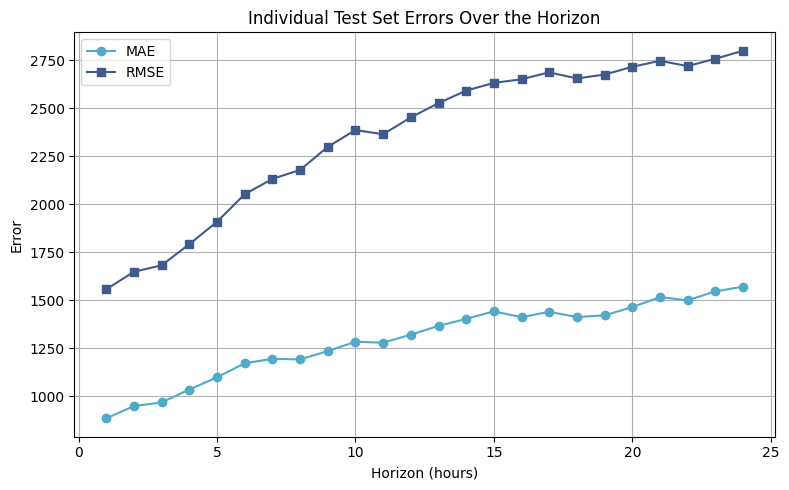

In [49]:
plot_error_over_horizon(y_lagged_test, xgb_pred_lagged, horizon=horizon)

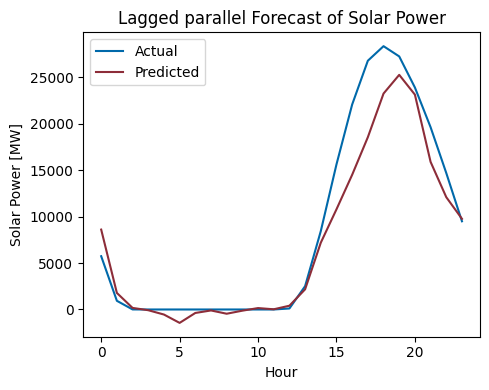

In [60]:
# plot random forecasts from the lagged XGBoost Parallel Prediction
plot_random_forecast(y_lagged_test, xgb_pred_lagged, model_name=xgb_lagged_eval.model_name)

In [51]:
# Lagged XGBoost Last Only Regressor Chain
last_only_lagged_chain = LastOnlyRegressorChain(
    xgb.XGBRegressor(
        n_estimators=1000,
        random_state=1312,
    )
)
last_only_lagged_chain.fit(X_lagged_train.to_numpy(), y_lagged_train.to_numpy())
xgb_pred_last_only_lagged = last_only_lagged_chain.predict(X_lagged_test.to_numpy())
r2_score_xgb_last_only_lagged = last_only_lagged_chain.score(X_lagged_test.to_numpy(), y_lagged_test)

Lagged Chained Last Only: R2: 0.8078509120204546


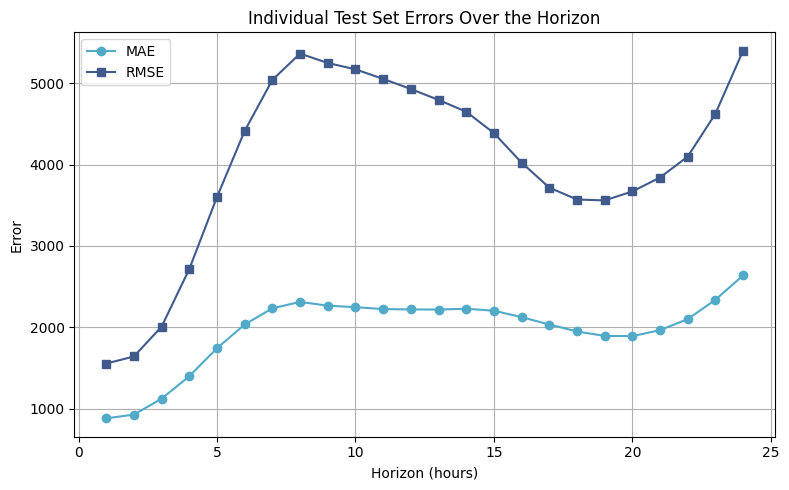

In [52]:
xgb_lagged_chain_eval = ModelEvaluation(
    model_name='Lagged Chained Last Only',
    model=last_only_lagged_chain,
    horizon=horizon,
    y_pred=pd.DataFrame(xgb_pred_last_only_lagged, index=y_lagged_test.index),
    R2_score=r2_score_xgb_last_only_lagged,
    RMSE=[root_mean_squared_error(y_lagged_test.iloc[:, i], xgb_pred_last_only_lagged[:, i]) for i in range(horizon)],
    MAE=[mean_absolute_error(y_lagged_test.iloc[:, i], xgb_pred_last_only_lagged[:, i]) for i in range(horizon)]
)
evaluations[xgb_lagged_chain_eval.model_name] = xgb_lagged_chain_eval
print(f"{xgb_lagged_chain_eval.model_name}: R2: {xgb_lagged_chain_eval.R2_score}")
plot_error_over_horizon(y_lagged_test, xgb_pred_last_only_lagged, horizon=horizon)

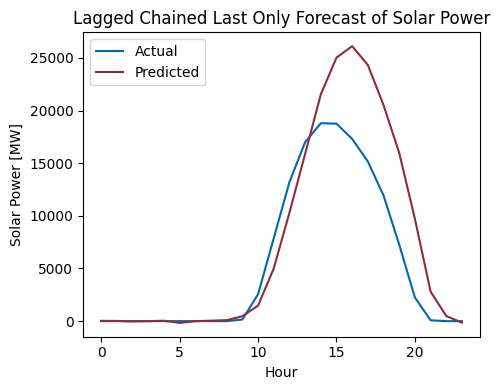

In [53]:
# plot random forecasts from the XGBoost Chained Parallel Prediction
plot_random_forecast(y_test_horizon, xgb_pred_last_only_lagged, model_name=xgb_lagged_chain_eval.model_name)

In [54]:
# Store the evaluations
with open('tmp/evaluations.pkl', 'wb') as f:
    pickle.dump(evaluations, f)

# 5. Evaluation
Now we can compare all the models.

In [55]:
# Load the evaluations
with open('tmp/evaluations.pkl', 'rb') as f:
    evaluations = pickle.load(f)
    
# Load y_lagged_test and y_test_horizon
y_lagged_test = pd.read_csv('tmp/y_lagged_test.csv', sep=';', decimal=',', index_col=0)
y_test_horizon = pd.read_csv('tmp/y_test_horizon.csv', sep=';', decimal=',', index_col=0)

In [56]:
# Give evaluations a color
colors = {
    "Parallel": rgb.tue_lightblue,
    "Chained": rgb.tue_red,
    "Chained Last Only": rgb.tue_ocre,
    "Lagged parallel": rgb.tue_darkblue,
    "Lagged Chained Last Only": rgb.tue_orange,
    "test data": rgb.tue_gray
}

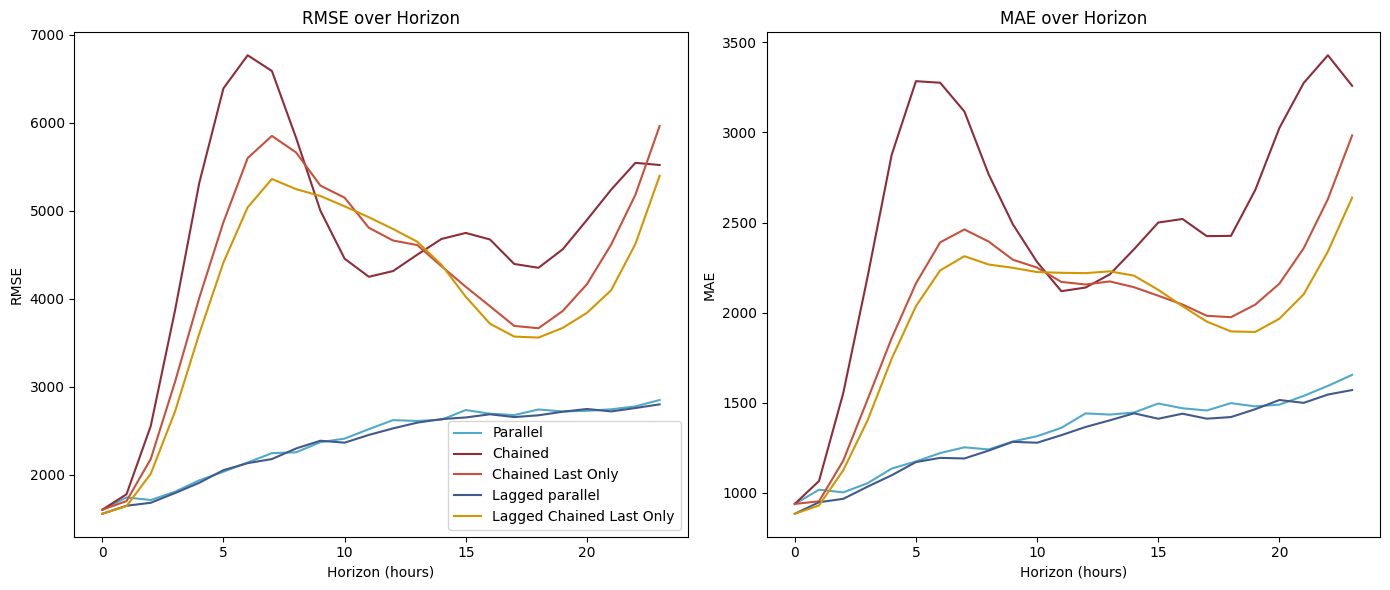

In [57]:
# Compare all evaluations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
for eval in evaluations.values():
    if eval.horizon > 1:
        ax1.plot(eval.RMSE, label=eval.model_name, color=colors.get(eval.model_name))
        ax2.plot(eval.MAE, label=eval.model_name, color=colors.get(eval.model_name))

ax1.set_title("RMSE over Horizon")
ax1.set_xlabel("Horizon (hours)")
ax1.set_ylabel("RMSE")
ax1.legend()
ax2.set_title("MAE over Horizon")
ax2.set_xlabel("Horizon (hours)")
ax2.set_ylabel("MAE")
plt.tight_layout()
plt.show()

As we have already seen earlier, the parallel method of forecasting has much lower average error. The development of error over the horizon also makes intuitive sense where as the chained errors follow a much weirder trend.  
The goal with the chained prediction was to bring error down and to get smoother and more coherent forecasts. In the error department, we failed to outperform the parallel method, but let's check for smoothness.

We can measure 'Smoothness' via the **total variation** which is the sum of absolute differences between consecutive points. Lower TV means smoother forecasts.

In [58]:
def average_total_variation(y_pred: np.ndarray) -> float:
    """Calculate the total variation of a time series.
    y_pred: np.ndarray of shape (n_samples, horizon)
    """
    return np.average(np.sum(np.abs(np.diff(y_pred, axis=1)), axis=1))

Parallel: Shape: (8737, 24)
Chained: Shape: (8737, 24)
Chained Last Only: Shape: (8737, 24)
Lagged parallel: Shape: (8714, 24)
Lagged Chained Last Only: Shape: (8714, 24)


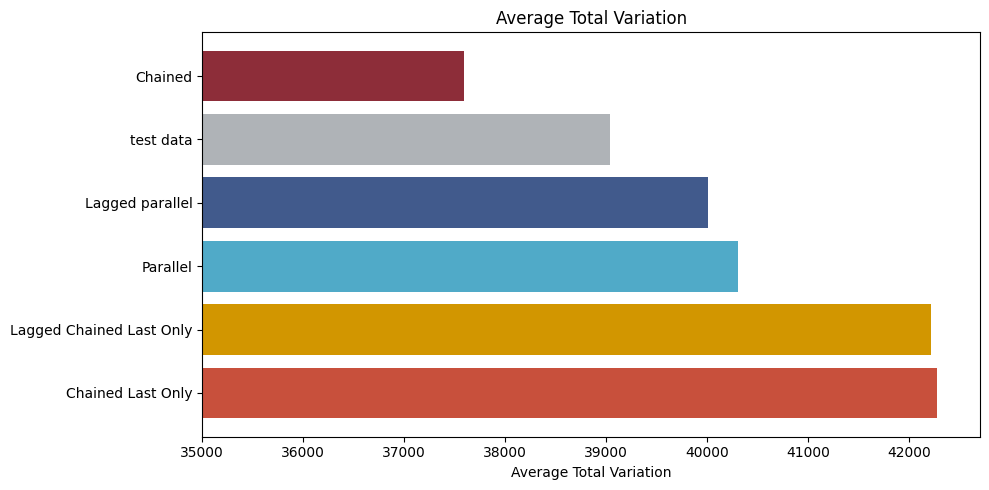

In [59]:
result_dict = {}
for eval in evaluations.values():
    if eval.horizon > 1:
        print(f"{eval.model_name}: Shape: {eval.y_pred.shape}")
        tv = average_total_variation(eval.y_pred.to_numpy())
        result_dict[eval.model_name] = tv
        
# add y_test_horizon to the result_dict
result_dict['test data'] = average_total_variation(y_test_horizon.to_numpy())

# sort the results
result_dict = dict(sorted(result_dict.items(), key=lambda item: item[1], reverse=True))

diff_plott = plt.figure(figsize=(10, 5))
plt.title('Average Total Variation')
for model_name, result in result_dict.items():
    plt.barh(model_name, result, label=model_name, color=colors.get(model_name))
    
plt.xlabel('Average Total Variation')
plt.xlim(35000, max(result_dict.values()) * 1.01)
#plt.xscale('log')
plt.tight_layout()
plt.show()

The plot shows the total variation averaged over all forecasts. Note the scale of the x-axis.  
The chained model with all previous predictions has the smoothest forecasts, and also the ones with the highest errors. This is not surprising, seeing that the forecasts are even smoother than test data.  
The last only chain models forecasts are even less smooth than the parallel models forecasts, failing in reducing the error and in increasing smoothness.  

This again shows, that the (lagged) parallel model is definitely the best one of the ones we have tested, for this particular task.